<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/WOOK/CCIT_graphcodeBert_N_N(%EA%B7%9C%EC%A0%9C_%EB%B0%8F_%EC%98%A4%EB%B2%84_%EC%83%98%ED%94%8C%EB%A7%81)_0531.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

In [76]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cwe file/ MSR+julite+Div_final_train(2500cut).csv')

In [77]:
df = df[df['CWE ID'] != 'CWE-399']

In [78]:
df['labels'] = df['labels'].replace(7, 6)

In [79]:
df['labels'] = df['labels'].replace(8, 7)

In [80]:
cwe_id_counts = df['CWE ID'].value_counts()
cwe_id_counts

CWE ID
CWE-119    2126
CWE-20     1520
CWE-415    1326
CWE-125    1177
CWE-787    1158
CWE-416     881
CWE-476     695
CWE-190     597
Name: count, dtype: int64

In [81]:
labels = df['labels'].value_counts()
labels

labels
0    2126
1    1520
2    1326
3    1177
4    1158
5     881
6     695
7     597
Name: count, dtype: int64

In [82]:
columns_to_drop = ['CWE ID', 'vul', 'lang']
df = df.drop(columns=columns_to_drop)

In [83]:
df.head()

,code,labels
0,"void func( IOBUF a, PACKET **pending_pkt, KBNO...",1
18,"void func(struct aeEventLoop *eventLoop, long ...",1
19,void func(struct aeEventLoop *eventLoop) { RED...,1
20,void func() { server.port = REDIS_SERVERPORT; ...,1
21,void func(redisClient *c) { listNode *ln; sdsf...,1


In [84]:
import pandas as pd
import re
import gensim
import transformers
from gensim.models import Word2Vec
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from pandas.core.common import random_state
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import logging
import sklearn.metrics as metric
from transformers import DataCollatorWithPadding
import torch,gc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from transformers import RobertaForSequenceClassification, RobertaTokenizer, TrainingArguments, Trainer

In [85]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("MickyMike/graphcodebert-c", num_labels=8)
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
tokenizer = AutoTokenizer.from_pretrained("MickyMike/graphcodebert-c")
batch_size = 16
epoch_num = 1000
MAX_LEN = 512
learning_rate = 2e-5

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at MickyMike/graphcodebert-c and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
import re
import pandas as pd
from datasets import Dataset
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
def preprocess(df, file_name):
    # 멀티 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df['code'] = df['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df.to_csv(file_name, index=False)
    return df  # 수정된 데이터프레임 반환

# 데이터셋을 Pandas DataFrame으로 변환
df = pd.DataFrame(df)

# 오버샘플링 적용
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df.drop(columns=['labels']), df['labels'])

# 오버샘플링 후 클래스 분포 확인
print(f"Resampled dataset shape: {Counter(y_res)}")

# 오버샘플링된 데이터를 다시 Dataset 객체로 변환
resampled_df = pd.concat([X_res, y_res], axis=1)
resampled_dataset = Dataset.from_pandas(resampled_df)

def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

Resampled dataset shape: Counter({1: 2126, 0: 2126, 6: 2126, 4: 2126, 7: 2126, 5: 2126, 2: 2126, 3: 2126})


In [87]:
preprocess(df,"preprocess.csv")
dataset = load_dataset("csv",data_files="preprocess.csv")['train']
encoded_dataset = resampled_dataset.map(tokenized,remove_columns=['code'],batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/17008 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [88]:
encoded_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17008
})

In [89]:
encoded_dataset = encoded_dataset.train_test_split(0.3,seed=100)

In [90]:
optimizer = torch.optim.AdamW(model.parameters(),
            lr = learning_rate, betas=(0.9,0.99), eps=1e-8,
            weight_decay=0.1)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer,
                                        num_warmup_steps=5, num_training_steps=5)
optimizers = optimizer, scheduler


In [91]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [92]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 각 클래스에 대한 F1 스코어 계산
    f1_per_class = f1_score(labels, predictions, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # 가중 평균, 매크로 평균, 마이크로 평균 F1 스코어 계산
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    # 결과를 딕셔너리 형태로 저장
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    # 클래스별 F1 스코어를 딕셔너리에 추가
    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1

    return metrics

In [93]:
from transformers import TrainerCallback
class CustomTrainerCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, early_stopping_patience=5):
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.incorrect_samples = []

    def on_evaluate(self, args, state, control, **kwargs):
        eval_loss = kwargs.get('metrics', {}).get('eval_loss')

        if eval_loss is not None:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.early_stopping_patience:
                print(f"No improvement in {self.early_stopping_patience} evaluation steps. Stopping training early.")
                control.should_training_stop = True

        # Evaluate를 위한 DataLoader 설정 및 평가 로직
        eval_dataloader = self.trainer.get_eval_dataloader(self.eval_dataset)
        self.trainer.model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(self.trainer.args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.trainer.model(**batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = batch['labels']
                incorrect_mask = predictions != labels

            if incorrect_mask.any():
                incorrect_samples = {k: v[incorrect_mask].cpu().numpy() for k, v in batch.items()}
                self.incorrect_samples.append(incorrect_samples)

        print("Collected incorrect predictions for further analysis.")

In [94]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='loss'
)

# 트레이너 초기화 및 사용자 정의 콜백 추가

# 콜백 인스턴스 생성 및 트레이너 초기화

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [95]:
callback = CustomTrainerCallback(trainer, encoded_dataset['test'], 5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    callbacks=[callback]
)


In [96]:
gc.collect()
torch.cuda.empty_cache()

In [97]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7
500,1.592900,1.180022,0.590437,0.590437,0.590898,0.589727,0.590437,0.454881,0.420643,0.940115,0.458284,0.600000,0.639807,0.584987,0.619099
1000,0.776300,0.624532,0.804233,0.804233,0.804661,0.803509,0.804233,0.652549,0.723636,0.956450,0.763720,0.814361,0.830842,0.793713,0.892805
1500,0.479500,0.448949,0.861258,0.861258,0.860556,0.859296,0.861258,0.718346,0.801319,0.967159,0.833977,0.863675,0.873178,0.878684,0.938026
2000,0.225600,0.460683,0.873996,0.873996,0.873028,0.871650,0.873996,0.722363,0.807947,0.967742,0.862237,0.870253,0.909377,0.895317,0.937962
2500,0.172600,0.530913,0.884382,0.884382,0.885189,0.883793,0.884382,0.751868,0.828139,0.966454,0.884127,0.876923,0.876732,0.929249,0.956851
3000,0.134800,0.484143,0.896727,0.896727,0.896452,0.895236,0.896727,0.764901,0.855401,0.975767,0.862399,0.898263,0.932177,0.918467,0.954512
3500,0.068900,0.513977,0.901822,0.901822,0.901512,0.900204,0.901822,0.774684,0.840032,0.977492,0.913540,0.884676,0.921779,0.937546,0.951887
4000,0.072700,0.546214,0.905154,0.905154,0.903908,0.902742,0.905154,0.780446,0.856897,0.977600,0.888383,0.904531,0.924943,0.929379,0.959762


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


TrainOutput(global_step=4000, training_loss=0.4404048118591309, metrics={'train_runtime': 2163.0245, 'train_samples_per_second': 55.039, 'train_steps_per_second': 3.444, 'total_flos': 1.68202803001344e+16, 'train_loss': 0.4404048118591309, 'epoch': 5.369127516778524})

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


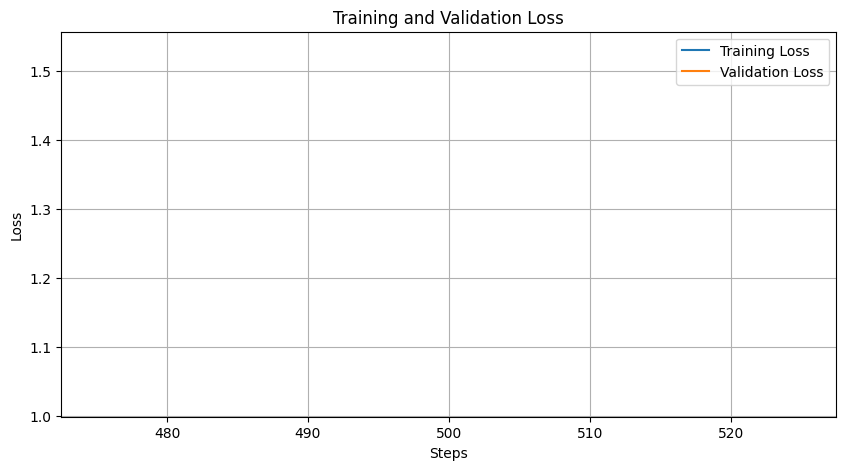

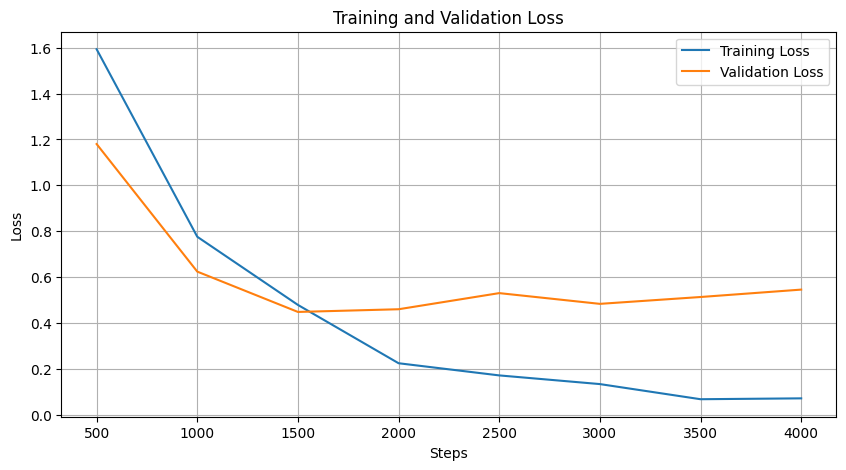

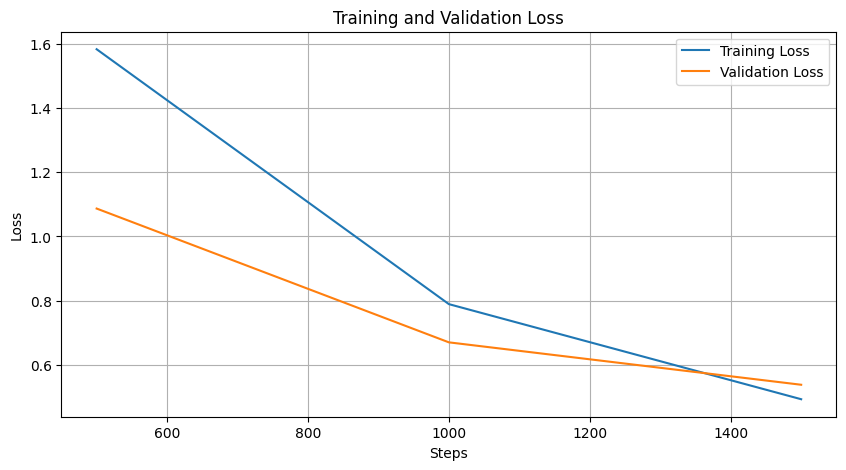

In [98]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')

In [ ]:
test_dataset = encoded_dataset['test']

In [ ]:
# 평가 데이터셋에 대한 예측 수행
predictions = trainer.predict(test_dataset)

Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8,F1 Class 9
500,1.953400,1.586775,0.452398,0.452398,0.433294,0.433220,0.452398,0.465524,0.184133,0.353372,0.426678,0.451264,0.887425,0.439731,0.299535,0.227395,0.597143
1000,1.380900,1.130584,0.631055,0.631055,0.632301,0.630997,0.631055,0.706886,0.427541,0.472163,0.533659,0.570591,0.916919,0.706800,0.654384,0.556911,0.764120
1500,0.931700,0.859886,0.740288,0.740288,0.743460,0.742164,0.740288,0.770335,0.521387,0.591652,0.711601,0.724619,0.943750,0.716740,0.779268,0.778646,0.883639
2000,0.728700,0.713580,0.778417,0.778417,0.777535,0.775864,0.778417,0.816471,0.564223,0.626524,0.700000,0.740299,0.948403,0.820815,0.812683,0.828623,0.900599
2500,0.594900,0.704049,0.805635,0.805635,0.804791,0.802808,0.805635,0.833532,0.560455,0.722034,0.765376,0.732538,0.947821,0.845488,0.848761,0.863919,0.908157
3000,0.432200,0.627086,0.826379,0.826379,0.828341,0.826780,0.826379,0.833530,0.606128,0.747586,0.786674,0.798011,0.954988,0.871795,0.868405,0.883777,0.916909
3500,0.446100,0.651130,0.825300,0.825300,0.824664,0.822506,0.825300,0.840580,0.583582,0.801536,0.787645,0.706341,0.957108,0.878484,0.870277,0.871226,0.928285
4000,0.360400,0.639209,0.834892,0.834892,0.834818,0.833426,0.834892,0.834206,0.631773,0.770270,0.790618,0.799494,0.962149,0.894291,0.900123,0.882827,0.868505
4500,0.313800,0.586272,0.855276,0.855276,0.854904,0.853693,0.855276,0.836464,0.677223,0.808564,0.827853,0.810738,0.963958,0.891100,0.889831,0.889888,0.941313
5000,0.314400,0.623513,0.860072,0.860072,0.857866,0.856361,0.860072,0.866169,0.658246,0.823109,0.835294,0.816597,0.955277,0.904762,0.864984,0.900112,0.939060


In [ ]:
# 예측된 레이블과 실제 레이블 추출
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# 각 클래스별 F1 스코어 계산
class_f1_scores = f1_score(true_labels, predicted_labels, average=None)

# 클래스별 F1 스코어 출력
for class_id, f1_score_value in enumerate(class_f1_scores):
    print(f"Class {class_id} F1 Score: {f1_score_value}")

Class 0 F1 Score: 0.8464501926252064
Class 1 F1 Score: 0.6722790138304269
Class 2 F1 Score: 0.8275862068965517
Class 3 F1 Score: 0.8639798488664988
Class 4 F1 Score: 0.831028262176789
Class 5 F1 Score: 0.9662369551872314
Class 6 F1 Score: 0.9165644171779141
Class 7 F1 Score: 0.9110012360939432
Class 8 F1 Score: 0.9161437535653166
Class 9 F1 Score: 0.9557522123893805


In [ ]:
trainer.save_model('/content/drive/MyDrive/models/CCIT_codebert_N:N(05-16)')

In [ ]:
import pandas as pd

df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/model train/MSR+julite+Div_final_test.csv")

In [ ]:
df2.head(50)

,CWE ID,vul,lang,code,labels
0,safe,0,c,"void func(fz_context *ctx, pdf_processor *proc...",0
1,safe,0,c,"void func(OM_uint32 *minor_status, gss_name_t ...",0
2,safe,0,c,void func(RedChannelClient *rcc) { rcc->destro...,0
3,safe,0,c,"void func(SplDoublyLinkedList, offsetSet) { zv...",0
4,safe,0,c,void func(VirtQueue *vq) { },0
5,safe,0,c,void func(struct kvm_vcpu *vcpu) { ++vcpu->sta...,0
6,safe,0,c,"asmlinkage void func(char __user *name, int le...",0
7,safe,0,c,\nstatic void func()\n{\n int * data;\n ...,0
8,safe,0,c,"void func(void *payload, void *data, const xml...",0
9,safe,0,c,void func(void *opaque) { struct vmsvga_state_...,0


In [ ]:
df2 = df2[['vul', 'code']]

In [ ]:
import re

def preprocess2(df2, file_name):
    # 멀티 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df2['code'] = df2['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df2['code'] = df2['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df2['code'] = df2['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df2['code'] = df2['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df2['code'] = df2['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    df2['code'] = df2['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df2.to_csv(file_name, index=False)
    return df2  # 수정된 데이터프레임 반환


def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

In [ ]:
preprocess2(df2,"preprocess2.csv")
dataset = load_dataset("csv",data_files="preprocess2.csv")['train']
encoded_dataset2 = dataset.map(tokenized,remove_columns=['code'],batched=True)
encoded_dataset2=encoded_dataset2.rename_column(original_column_name='vul',new_column_name='labels')

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
trainer.predict(encoded_dataset2, metric_key_prefix="eval")

Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8,F1 Class 9
500,1.953400,1.586775,0.452398,0.452398,0.433294,0.433220,0.452398,0.465524,0.184133,0.353372,0.426678,0.451264,0.887425,0.439731,0.299535,0.227395,0.597143
1000,1.380900,1.130584,0.631055,0.631055,0.632301,0.630997,0.631055,0.706886,0.427541,0.472163,0.533659,0.570591,0.916919,0.706800,0.654384,0.556911,0.764120
1500,0.931700,0.859886,0.740288,0.740288,0.743460,0.742164,0.740288,0.770335,0.521387,0.591652,0.711601,0.724619,0.943750,0.716740,0.779268,0.778646,0.883639
2000,0.728700,0.713580,0.778417,0.778417,0.777535,0.775864,0.778417,0.816471,0.564223,0.626524,0.700000,0.740299,0.948403,0.820815,0.812683,0.828623,0.900599
2500,0.594900,0.704049,0.805635,0.805635,0.804791,0.802808,0.805635,0.833532,0.560455,0.722034,0.765376,0.732538,0.947821,0.845488,0.848761,0.863919,0.908157
3000,0.432200,0.627086,0.826379,0.826379,0.828341,0.826780,0.826379,0.833530,0.606128,0.747586,0.786674,0.798011,0.954988,0.871795,0.868405,0.883777,0.916909
3500,0.446100,0.651130,0.825300,0.825300,0.824664,0.822506,0.825300,0.840580,0.583582,0.801536,0.787645,0.706341,0.957108,0.878484,0.870277,0.871226,0.928285
4000,0.360400,0.639209,0.834892,0.834892,0.834818,0.833426,0.834892,0.834206,0.631773,0.770270,0.790618,0.799494,0.962149,0.894291,0.900123,0.882827,0.868505
4500,0.313800,0.586272,0.855276,0.855276,0.854904,0.853693,0.855276,0.836464,0.677223,0.808564,0.827853,0.810738,0.963958,0.891100,0.889831,0.889888,0.941313
5000,0.314400,0.623513,0.860072,0.860072,0.857866,0.856361,0.860072,0.866169,0.658246,0.823109,0.835294,0.816597,0.955277,0.904762,0.864984,0.900112,0.939060


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PredictionOutput(predictions=array([[ 8.6874275e+00, -1.4084761e-01,  2.5200475e-02, -1.6101687e+00,
        -5.0566298e-01, -5.3870064e-01, -1.8166504e+00, -9.9665213e-01,
        -1.1870959e+00, -1.0926784e+00],
       [ 6.1669712e+00,  4.6067448e+00, -6.5555757e-01, -1.6233778e+00,
        -3.1170696e-01, -1.4861598e+00, -2.5030525e+00, -1.9365594e+00,
        -1.7443881e+00, -1.2906655e+00],
       [ 8.6647606e+00, -1.4702669e-01, -1.0398152e-01, -1.6217979e+00,
        -5.4898900e-01, -4.3760145e-01, -1.6488084e+00, -9.8503900e-01,
        -9.9934042e-01, -1.2720542e+00],
       [ 7.8117237e+00, -1.3841354e+00, -4.0079731e-01, -1.4776322e+00,
        -1.8548945e+00,  2.9325774e+00, -2.0682461e+00, -2.0252827e-01,
        -1.3874626e+00, -5.8423913e-01],
       [ 8.5519352e+00,  3.3892900e-01, -1.7676924e-01, -1.2032121e+00,
        -1.1123953e-01, -1.2170610e+00, -2.0994344e+00, -1.0020629e+00,
        -1.0783482e+00, -1.3238137e+00],
       [ 7.7605562e+00, -2.8440151e-01,  2.097